<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# MTBS Fire Modeling Demo

_by Jeremy Freeman (CarbonPlan), September 19, 2020_

This notebook loads munged, downsampled MTBS fire data and TerraClimate climate
data and fits a simple logistical regression model.

Before getting started you'll need to download this file:
https://storage.googleapis.com/carbonplan-data/processed/mtbs/conus/16000m/training.pkl.

A file with the same contents is available in parquet:
https://storage.googleapis.com/carbonplan-data/processed/mtbs/conus/16000m/training.parquet.


### Setup


In [5]:
from showit import image
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
warnings.simplefilter(action='ignore', category=RuntimeWarning)
%matplotlib inline

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data


We've already munged the data into two dictionaries: X (with our regressors) and
y (with our fire data). We're using the downsampled data for speed and
simplicity. At higher resolutions, similar approaches should work, and
additional techniques could possibly be included.


In [6]:
from carbonplan_forests import load

In [38]:
coarsen = 4
data_vars = ["ppt", "ppt", "ppt", "tmax", "tmax", "tmax", "tmin", "tmin", "tmin", "pdsi", "pet", "aet"]
aggs = ["sum", "min", "max", "mean", "min", "max", "mean", "min", "max", "mean", "mean", "mean"]

In [39]:
y = load.mtbs(store="local", coarsen=coarsen)

In [40]:
mask = load.nlcd(store='local', classes='all', year=2001)
climate = load.terraclim(store="local", tlim=(1984, 2018), coarsen=coarsen, data_vars=data_vars, aggs=aggs, mask=mask)

In [584]:
groups = load.nftd(
    store="local",
    groups="all",
    return_type="numpy",
    coarsen=4,
)
for key in range(groups.shape[0]):
    if key > 0:
        X[f"group_{key}"] = np.tile(groups[key], [len(time), 1, 1])

In [586]:
X.keys()

dict_keys(['ppt_sum', 'ppt_min', 'ppt_max', 'tmax_mean', 'tmax_min', 'tmax_max', 'tmin_mean', 'tmin_min', 'tmin_max', 'pdsi_mean', 'pet_mean', 'aet_mean', 'forested', 'group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15', 'group_16', 'group_17', 'group_18', 'group_19', 'group_20', 'group_21', 'group_22', 'group_23', 'group_24', 'group_25', 'group_26', 'group_27'])

There's one `y` variable `burned_area` and several `X` variables


In [425]:
X.keys()

dict_keys(['ppt_sum', 'ppt_min', 'ppt_max', 'tmax_mean', 'tmax_min', 'tmax_max', 'tmin_mean', 'tmin_min', 'tmin_max', 'pdsi_mean', 'pet_mean', 'aet_mean', 'forested', 'group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15', 'group_16', 'group_17', 'group_18', 'group_19', 'group_20', 'group_21', 'group_22', 'group_23', 'group_24', 'group_25', 'group_26', 'group_27'])

For some simple summary statistics, we can look at the spatial distribution of
burned area averaged across years


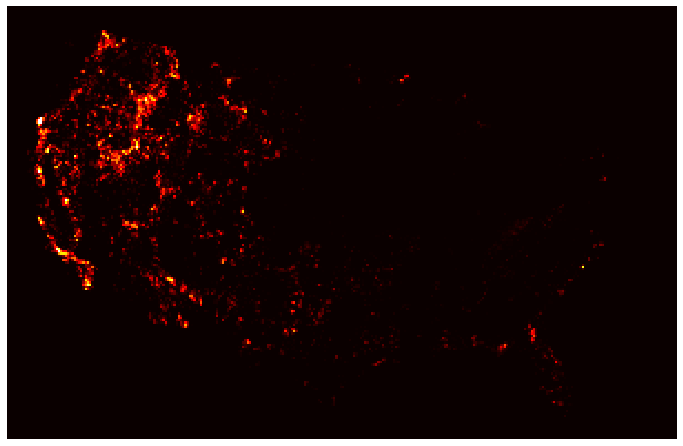

In [528]:
image((y["burned_area"]).sum(axis=0), clim=(0, 1), cmap="hot", size=12)

Here's the max temperature (max daily maxed across months averaged across years)


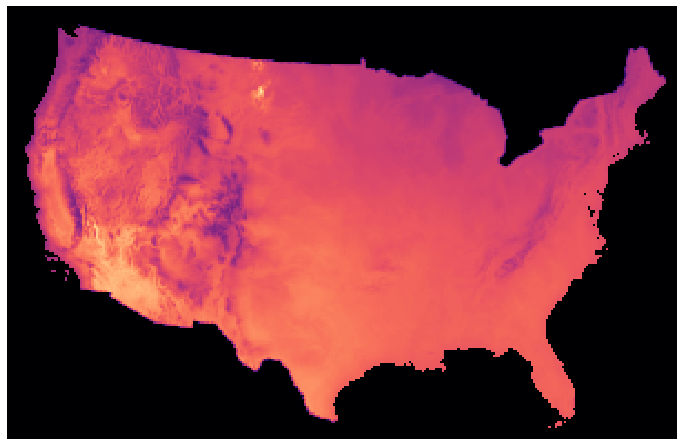

In [41]:
image(climate["tmax_max"].mean(axis=0), clim=(0, 50), cmap="magma", size=12)

And here's the fraction of each grid cell that is forested from NLCD


In [ ]:
image(X["forested"].mean(axis=0), clim=(0, 1), cmap="bone", size=12)

We can also look at dynamics over time avearged across space. We'll make a quick
plotting function.


In [48]:
zscore = lambda x: (x - x.mean()) / x.std()


def plot_time_vars(var1, var2):
    y1 = zscore(np.nanmean(climate[var1].values.reshape(len(X['time']), -1), axis=1))
    y2 = zscore(np.nanmean(y[var2].values.reshape(len(X['time']), -1), axis=1))
    plt.plot(X['time'], y1)
    plt.plot(X['time'], y2)
    plt.legend([var1, var2])
    plt.xlabel("time")
    plt.ylabel(f"{var1} (zscored)")
    plt.figure()
    plt.plot(y1, y2, ".")
    plt.xlabel(var1)
    plt.ylabel(var2)

First we'll look at the positive relationship between maximum temperature and
burned area


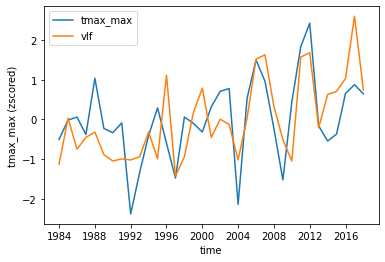

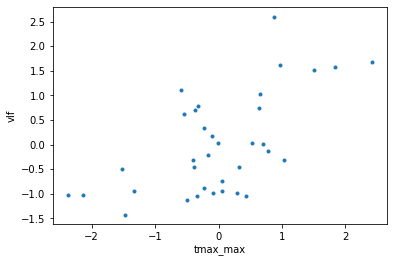

In [49]:
plot_time_vars("tmax_max", "vlf")

And now we'll look at the negative relationship with maximum precipitation.


In [ ]:
plot_time_vars("ppt_sum", "burned_area")

### Fit a model


Now we build a super simple space-time separable logistic regression model to
predict fraction burned as a function of climatic variables.


First we define our dimensions


In [649]:
t = len(time)
n, m = y["burned_area"].shape[1:]

We are going to construct a `(t)(n)(m) x (2v - 1)` design matrix where each of
our climatic variables appears twice, once where we have averaged across space
and replicated across time, and again where we have averaged across time and
replicated across space.


When building the temporal component we skip `forested` because that variable is
constant over time.


In [432]:
X.keys()

dict_keys(['ppt_sum', 'ppt_min', 'ppt_max', 'tmax_mean', 'tmax_min', 'tmax_max', 'tmin_mean', 'tmin_min', 'tmin_max', 'pdsi_mean', 'pet_mean', 'aet_mean', 'forested', 'group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15', 'group_16', 'group_17', 'group_18', 'group_19', 'group_20', 'group_21', 'group_22', 'group_23', 'group_24', 'group_25', 'group_26', 'group_27'])

In [650]:
X_s = np.asarray(
    [
        np.tile(np.nanmean(X[var], axis=0).flatten(), [1, t]).squeeze()
        for var in ['ppt_sum', 'ppt_min', 'ppt_max', 'tmax_mean', 'tmax_min', 'tmax_max', 'tmin_mean', 'tmin_min', 'tmin_max', 'pdsi_mean', 'pet_mean', 'aet_mean','forested']
    ]
)

X_t = np.asarray(
    [
        np.tile(np.nanmean(X[var].reshape(t, n * m), axis=1), [n * m, 1])
        .T.flatten()
        .squeeze()
        for var in ['ppt_sum', 'ppt_min', 'ppt_max', 'tmax_mean', 'tmax_min', 'tmax_max', 'tmin_mean', 'tmin_min', 'tmin_max', 'pdsi_mean', 'pet_mean', 'aet_mean']
    ]
).squeeze()

We combine them together to get our full design matrix


In [651]:
#X_st = np.vstack([X_s, X_t]).T
X_st = np.asarray([X[var].flatten() for var in X.keys()]).T
print(f"shape: {X_st.shape}")

shape: (2061150, 40)


We turn fraction burned into a binary variable using a threshold, and flatten it


In [646]:
np.random.shuffle(y["burned_area"])

In [652]:
y_b = y["burned_area"].flatten() > 0.05

And we identify all rows that are nans in any of our variables


In [653]:
inds = (~np.isnan(X_st.sum(axis=1))) & (~np.isnan(y_b))

In [438]:
# train_inds = (np.random.random(y_b[inds].shape) > 0.8)
# test_inds = ~train_inds

Finally we create a function for zscoring our variables


In [639]:
def zscore_2d(x, mean=None, std=None):
    recomputing = False
    if mean is None or std is None:
        recomputing = True
    if mean is None:
        mean = x.mean(axis=0)
    if std is None:
        std = x.std(axis=0)
    if recomputing:
        return mean, std, (x - mean) / std
    else:
        return (x - mean) / std

Now let's define and fit the model


In [654]:
train_mean, train_std, zscored = zscore_2d(X_st[inds])
model = LogisticRegression(fit_intercept=True, max_iter=500, solver="lbfgs")
model.fit(zscored, y_b[inds])

LogisticRegression(max_iter=500)

Let's inspect the predictions by computing estimated fraction burned


In [655]:
y_hat = model.predict_proba(zscored)[:, 1]

We can calculate a quick and dirty ROC score `WARNING NOT CROSS VALIDATED!`


In [642]:
roc_auc_score(y_b[inds], y_hat)

0.890715957114771

To inspect it visually, we need to reconstitute the full tensor by inverting our
NaN removal step


In [656]:
y_hat_full = np.zeros((t, n, m)).flatten()
y_hat_full[inds] = y_hat
y_hat_full = y_hat_full.reshape(t, n, m)

First we'll look at the model's prediction across time


Text(0, 0.5, 'fraction burned')

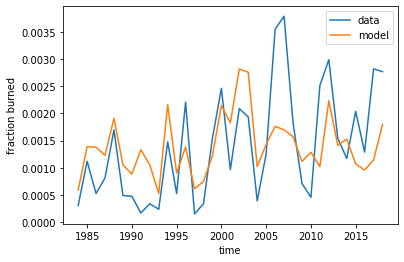

In [657]:
plt.plot(time, np.nanmean(y_b.reshape(t, n * m), axis=1))
plt.plot(time, np.nanmean(y_hat_full.reshape(t, n * m), axis=1))
plt.legend(["data", "model"])
plt.xlabel("time")
plt.ylabel("fraction burned")

And then we can do the same thing across space


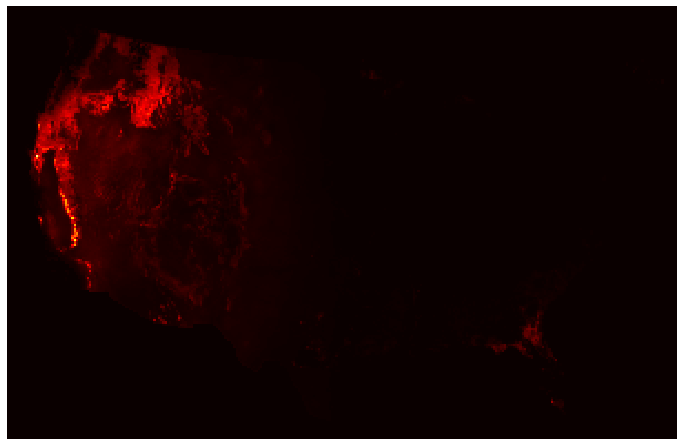

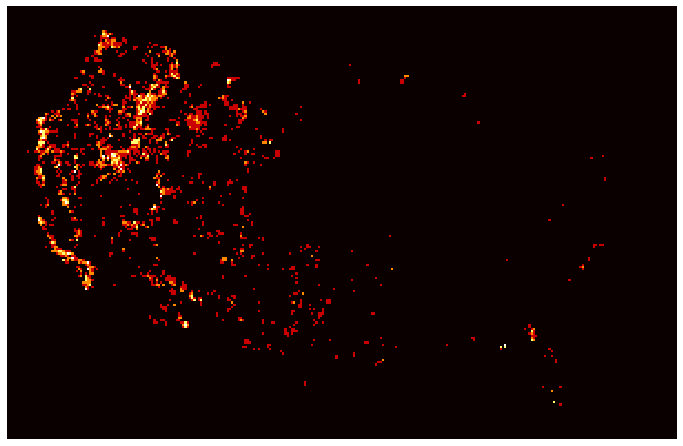

In [661]:
image(np.nanmean(y_hat_full, axis=0), size=12, clim=(0, 0.1), cmap="hot")
image(
    np.nanmean(y_b.reshape(t, n, m), axis=0), clim=(0, 0.1), cmap="hot", size=12
)

In [659]:
np.corrcoef(
    np.nanmean(y_b.reshape(t, n * m), axis=1),
    np.nanmean(y_hat_full.reshape(t, n * m), axis=1)
)

array([[1.        , 0.56854747],
       [0.56854747, 1.        ]])

In [660]:
np.corrcoef(
    np.nanmean(y_b.reshape(t, n, m), axis=0).flatten(),
    np.nanmean(y_hat_full, axis=0).flatten()
)

array([[1.        , 0.44432598],
       [0.44432598, 1.        ]])

Finally, as a sanity check, we can show that if we use only the spatial or
temporal component the fit gets worse, and the latter is much worse given that
the total dataset varies much more substantially over space than time


In [ ]:
model.fit(zscore_2d(X_s.T[inds]), y_b[inds])
y_hat_s = model.predict_proba(zscore_2d(X_s.T[inds]))[:, 1]
score_s = roc_auc_score(y_b[inds], y_hat_s)
print(f"spatial only: {score_s}")

In [ ]:
model.fit(zscore_2d(X_t.T[inds]), y_b[inds])
y_hat_t = model.predict_proba(zscore_2d(X_t.T[inds]))[:, 1]
score_t = roc_auc_score(y_b[inds], y_hat_t)
print(f"temporal only: {score_t}")

### Projections


In [ ]:
n, m = y["burned_area"].shape[1:]

In [ ]:
scenarios = ["ssp245", "ssp370", "ssp585"]
for scenario in scenarios:
    Xhat = load.cmip(
        model="BCC-CSM2-MR",
        scenario=scenario,
        coarsen=coarsen,
        store="local",
        tlim=(2015, 2100),
        mean=False,
        return_type="numpy",
        vars=["ppt", "tmax", "tmax", "tmax", "tmin", "tmin", "tmin"],
        aggs=["sum", "mean", "min", "max", "mean", "min", "max"],
    )

    t = Xhat["tmax_max"].shape[0]
    mask = load.nlcd(
        store="local",
        classes=[41, 42, 43, 51, 52, 90],
        year=2001,
        coarsen=coarsen,
        return_type="numpy",
    )
    Xhat["forested"] = np.tile(mask, [t, 1, 1])

    allmask = load.nlcd(
        store="local",
        classes="all",
        year=2001,
        return_type="numpy",
        coarsen=coarsen,
    )
    for key in Xhat.keys():
        Xhat[key][np.tile(allmask == 0, [t, 1, 1])] = np.NaN

    Xhat_s = np.asarray(
        [
            np.tile(np.nanmean(Xhat[var], axis=0).flatten(), [1, t]).squeeze()
            for var in Xhat.keys()
        ]
    )

    keys = list(Xhat.keys())
    keys.remove("forested")
    Xhat_t = np.asarray(
        [
            np.tile(np.nanmean(Xhat[var].reshape(t, n * m), axis=1), [n * m, 1])
            .T.flatten()
            .squeeze()
            for var in keys
        ]
    ).squeeze()

    Xhat_st = np.vstack([Xhat_s, Xhat_t]).T
    inds = ~np.isnan(Xhat_st.sum(axis=1))
    y_proj = model.predict_proba(
        zscore_2d(Xhat_st[inds], mean=train_mean, std=train_std)
    )[:, 1]
    y_proj_full = np.zeros((t, n, m)).flatten()
    y_proj_full[inds] = y_proj
    y_proj_full = y_proj_full.reshape(t, n, m).squeeze()

    mask2 = load.nlcd(
        store="local",
        classes=[41, 42, 43, 90],
        coarsen=coarsen,
        year=2001,
        return_type="numpy",
    )
    mask2 = mask2 > 0.5

    y_proj_full = y_proj_full * np.tile(mask2, [t, 1, 1])

    plt.plot(np.nanmean(y_proj_full.reshape(86, 195 * 302), axis=1))

In [ ]:
yt = np.nanmean(y_proj_full.reshape(86, 195 * 302), axis=1)

In [ ]:
image(y_proj_full[0:10].mean(axis=0), clim=(0, 0.5), cmap="hot", size=12)

In [ ]:
a = y_proj_full
image(a, clim=(0, 0.5), cmap="hot", size=12)

In [ ]:
image(
    mask2 * y_proj_full[70:80].mean(axis=0),
    clim=(0.05, 0.5),
    cmap="hot",
    size=12,
)

In [ ]:
plt.plot(np.nanmean(y_proj_full.reshape(86, 195 * 302), axis=1))

In [ ]:
plt.plot(
    X["tmax_max"].mean(axis=0).flatten(),
    Xhat["tmax_max"].mean(axis=0).flatten(),
)
plt.axis("equal")

### Todo

This was just a demo. Lots more to do! Including:

- Proper performance evaluation and cross validation
- Variable selection
- Exploration of other variables (we have many more)
- Use of models that treat time / space more explicitly (e.g. via spatial
  kernels and convolution)
- Use of basis functions (e.g. GAMs)
- Running at full resolution
